#### 実装上の気づいたメモ
- appendしたいならnp.append, np.hstackの中ではlist.appendが一番早い
- zipしたいときはlistに戻さずnp.arrayのままzipするのが一番早い。np.arrayでzipしてもlistでzipしても速度は変わらない？
- 元のデータの精度に応じてモデルエビデンスが変わってくる。
    - 精度が大きいとき
        - 次元によって変わってくる
    - 精度が小さいとき
        - データ数が少ない⇛次元数の単調現象
            - これはデータのノイズが大きいから表現力高くしてもノイズに適合するだけ、ってことか？
            - 数式上はΛ=λ(...)のλが大きくなるからdet|Λ*|が大きくなる
        - データ数が大きい
            - 次元によって変わってくる

In [192]:
import numpy as np
import scipy as sp
from scipy.stats import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
% matplotlib inline

def poly_x_vector(x, n_dim=3):
    # out = (n_dim+1, data_size)
    y = [x**dim for dim in range(n_dim+1)]
    return np.array(y)

def demo_linear_gaussian(seed=0, data_lam=0.5, n_dim=2):
    np.random.seed(seed)
    n_dim = n_dim
    pre_w_loc = np.zeros(n_dim+1)
    pre_w_lam = np.eye(n_dim+1)

    pre_data_lam = data_lam

    data_size = 50
    x = np.random.uniform(-5,5,data_size)
    x_ground = np.linspace(-5,5,100)

    w = np.random.multivariate_normal(mean=pre_w_loc, cov=np.linalg.inv(pre_w_lam), size = 1)


    y_mean = list(np.dot(w,poly_x_vector(x, n_dim=n_dim)).reshape(-1))
    y = np.array([np.random.normal(_y, 1./pre_data_lam) for _y in y_mean])
    y_ground = np.dot(w, poly_x_vector(x_ground, n_dim=n_dim))

    plt.scatter(x,y, color="B", alpha=0.5)
    plt.plot(x_ground, y_ground.reshape(-1))
    
def y_line(x):
    return 3*np.sin(x)

def fit_linear(f, seed=0, n_dim=2, ax=None, data_size=10, data_lam = 0.3, fit_result=True):
    np.random.seed(seed)
    pre_w_loc = np.zeros(n_dim+1)
    pre_w_lam = np.eye(n_dim+1)

    x_data = np.random.uniform(-3,3,data_size)
    y_data = f(x_data)
    x_ground = np.linspace(-3,3,100)
    y_ground = f(x_ground)
    x_test = poly_x_vector(x_ground, n_dim=n_dim)

    x_for_predict = poly_x_vector(x_data, n_dim=n_dim)
    
#     print("x_data shape:",x_for_predict.shape)
#     print("y_data shape:", y_data.shape)
    est_w_lam = data_lam*np.dot(x_for_predict, x_for_predict.T)+pre_w_lam
    est_w_lam_inv = np.linalg.inv(est_w_lam)
    _m1 = data_lam*np.sum(y_data*x_for_predict, axis=1)+np.dot(pre_w_lam,pre_w_loc)
    est_w_loc = np.dot(est_w_lam_inv, _m1)
    
#     print("est_w_loc shape:",est_w_loc.shape)
#     print("x_test shape:", x_test.shape)
    est_data_loc = np.dot(est_w_loc.T,x_test)
#     print("est_data_loc shape:",est_data_loc.shape)
    _m1 = np.dot(x_test.T, est_w_lam_inv)
#     print("_m1 shape:",_m1.shape)
#     print("x_test shape:",x_test.shape)
    est_data_lam = 1./(1/data_lam+np.sum(_m1.T*x_test, axis=0))
    
#     w = np.random.multivariate_normal(mean=pre_w_loc, cov=np.linalg.inv(pre_w_lam), size = 1)
    y_mean = est_data_loc
    y_one_sigma = (est_data_loc+1./est_data_lam, est_data_loc-1./est_data_lam)


    if fit_result:
        if ax is None:
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
        ax.scatter(x_data,y_data, color="black", alpha=0.5, label="True Data")
        ax.plot(x_ground, y_ground.reshape(-1), color="B", label="True Line")  
        ax.plot(x_ground, y_mean, color="orange", alpha=0.5, label="Estimate Mean Line")
        ax.plot(x_ground, y_one_sigma[0], color="pink", linestyle="dashed", alpha=0.5)
        ax.plot(x_ground, y_one_sigma[1], color="pink", linestyle="dashed", alpha=0.5)

        plt.legend()
    
        plt.ylim(-5,5)
        plt.title("dimension = {}".format(n_dim))
#     print("-------------------------------")
    _m1 = np.sum(data_lam*y_data**2-np.log(data_lam)+math.log(2*math.pi))
#     print("_m1:",_m1)
    _m2 = np.dot(np.dot(pre_w_loc, pre_w_lam), pre_w_loc)-math.log(np.linalg.det(pre_w_lam))
#     print("_m2:",_m2)
    
    _m3 = -np.dot(np.dot(est_w_loc, est_w_lam), est_w_loc)+math.log(np.linalg.det(est_w_lam))
#     print("est w lam det:",math.log(np.linalg.det(est_w_lam)))
#     print("_m3:",_m3)
    
    log_model_evidence = -0.5*(_m1+_m2+_m3)
    print("dim = {} model evidence:".format(n_dim), log_model_evidence)
    return log_model_evidence 

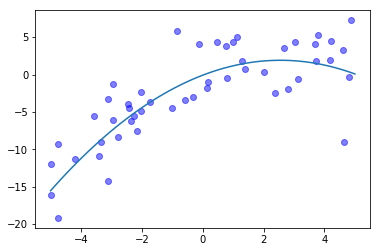

In [187]:
demo_linear_gaussian(5, data_lam=0.3)

dim = 0 model evidence: -23.07333585494294
dim = 1 model evidence: -18.29177832612657
dim = 2 model evidence: -16.724354008588104
dim = 3 model evidence: -17.566679914640687
dim = 4 model evidence: -18.915507398261354
dim = 5 model evidence: -20.747232101781844
dim = 6 model evidence: -22.759865071797847
dim = 7 model evidence: -24.82881058947152
dim = 8 model evidence: -27.02908902433206
dim = 9 model evidence: -29.241457672586307
dim = 10 model evidence: -31.444367865277002


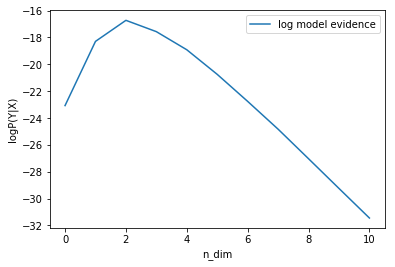

In [194]:
max_dim=10
log_model_evidence = [fit_linear(y_line, data_size=10, n_dim=i, data_lam=1, fit_result=False) for i in range(max_dim+1)]

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(range(max_dim+1), log_model_evidence, label="log model evidence")
ax.set_ylabel("logP(Y|X)")
ax.set_xlabel("n_dim")
plt.legend()

### （補足）np.append, listのappend, np.hstackの速度比較

In [19]:
print("list append")
start = time.time()

y = []
for i in range(100000):
    y.append(i)
y = np.array(y)
print("time:{}".format(time.time()-start))
print(y)
print("np.append")
start = time.time()

y = np.empty(0)
for i in range(100000):
    y = np.append(y,i)
print("time:{}".format(time.time()-start))
print(y)

print("np.hstack")
start = time.time()

y = np.empty(0)
for i in range(100000):
    y = np.hstack([y,i])
print("time:{}".format(time.time()-start))
print(y)

list append
time:0.012807846069335938
[    0     1     2 ... 99997 99998 99999]
np.append
time:1.439699411392212
[0.0000e+00 1.0000e+00 2.0000e+00 ... 9.9997e+04 9.9998e+04 9.9999e+04]
np.hstack
time:1.5335378646850586
[0.0000e+00 1.0000e+00 2.0000e+00 ... 9.9997e+04 9.9998e+04 9.9999e+04]
